# 12-1. 프로젝트: ControlNet으로 조건을 준 이미지 생성하기

- ControlNet을 사용하여 이미지에 조건을 주어 이미지를 다양하게 변형

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# 메모리 삭제
import torch
torch.cuda.empty_cache()

## 윤곽선 검출
- 이미지를 불러오기


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

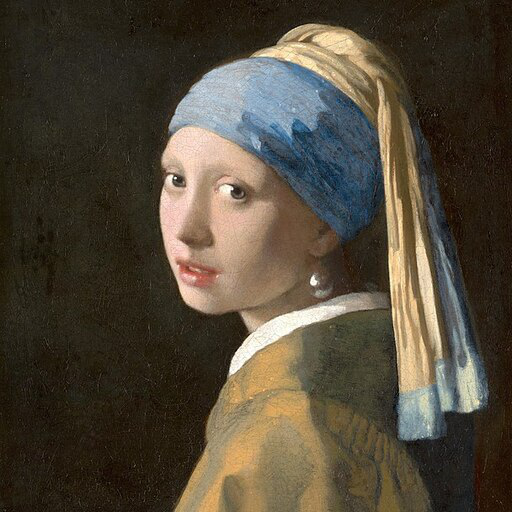

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 


# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

### OpenCV를 사용하여 이미지의 윤곽선을 검출

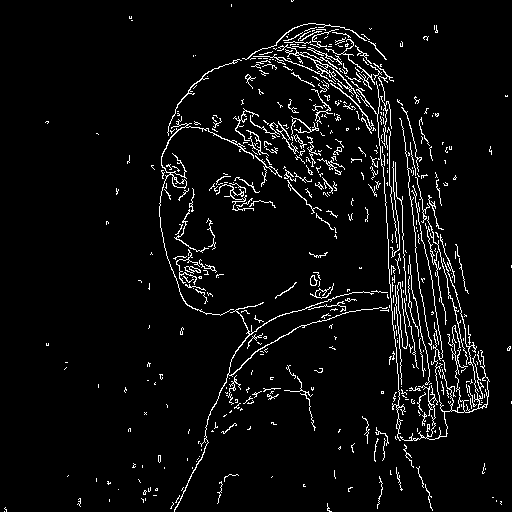

In [4]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

### 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오기

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성

  0%|          | 0/20 [00:00<?, ?it/s]

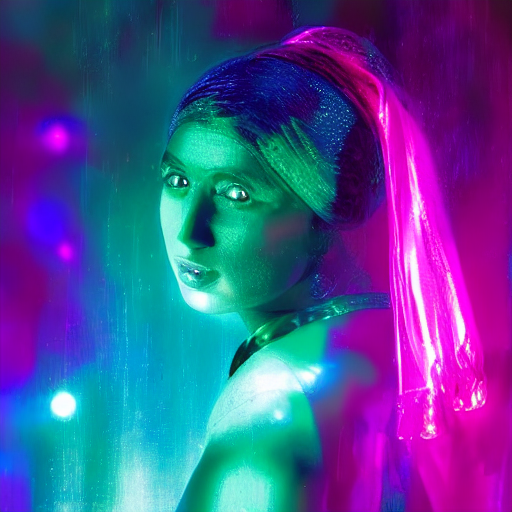

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있습니다.

- ```negative_propmt```: 원하지 않는 요소를 적을 수 있습니다.
- ```controlnet_conditioning_scale```: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- ```num_inference_steps```: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- ```guidance_scale```: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.

프롬프트와 부정적인 프롬프트는 ChatGPT를 이용하여 생성해 보세요. 직접 프롬프트를 작성하는 것보다 더 멋진 이미지를 생성할 수 있어요.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

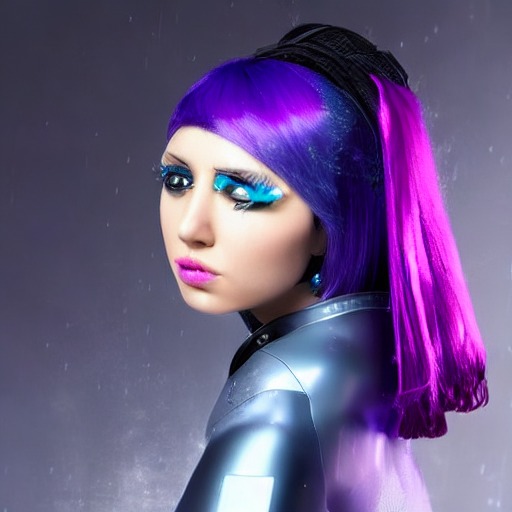

In [7]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# [[YOUR CODE]]import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
from diffusers import UniPCMultistepScheduler
import cv2
from PIL import Image
import numpy as np

# 이미지 로드
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# 이미지를 Canny 엣지 검출을 사용하여 처리합니다.
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(image, low_threshold, high_threshold)
edges = edges[:, :, None]
edges = np.concatenate([edges, edges, edges], axis=2)
canny_image = Image.fromarray(edges)

# ControlNet 모델과 파이프라인을 불러옵니다.
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 시드 설정
generator = torch.manual_seed(0)

# 이미지 생성
canny_image = canny_pipe(
    prompt="futuristic style, purple hair with Bangs,cyber robotic",
    negative_prompt="Natur face",
    controlnet_conditioning_scale=1.2,
    num_inference_steps=20,
    guidance_scale=10.0,
    generator=generator,
    image=canny_image
).images[0]

# 이미지 저장
canny_image.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지 출력
canny_image.show()

## 인체 자세 감지
- Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리

In [8]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

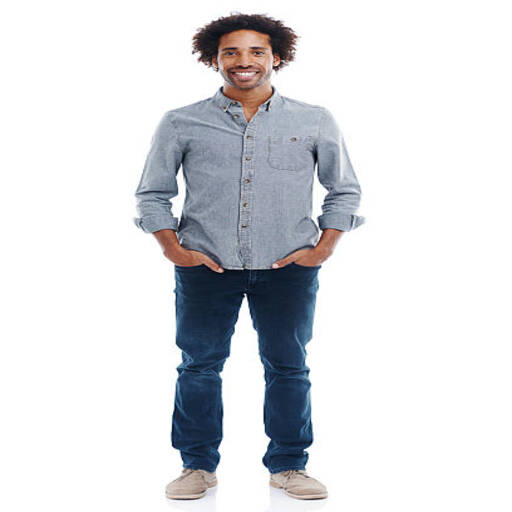

In [9]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

- Openpose 검출기를 사용하면 자세만 추출

cuda


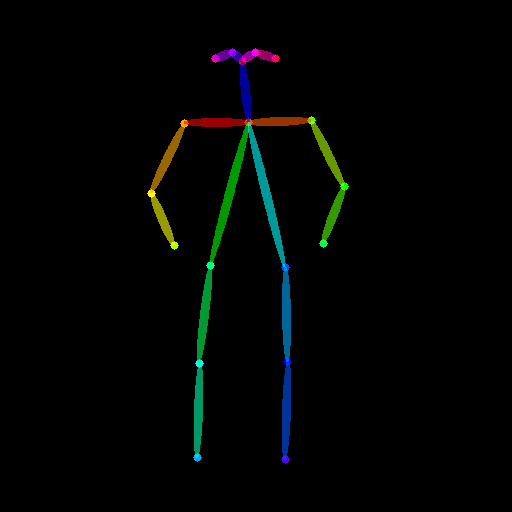

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

- Openpose 전처리기를 사용한 모델 파이프라인을 불러옵니다.

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


 - Canny Edge Detection에서 사용한 코드를 참고하여 직접 코드를 작성

  0%|          | 0/20 [00:00<?, ?it/s]

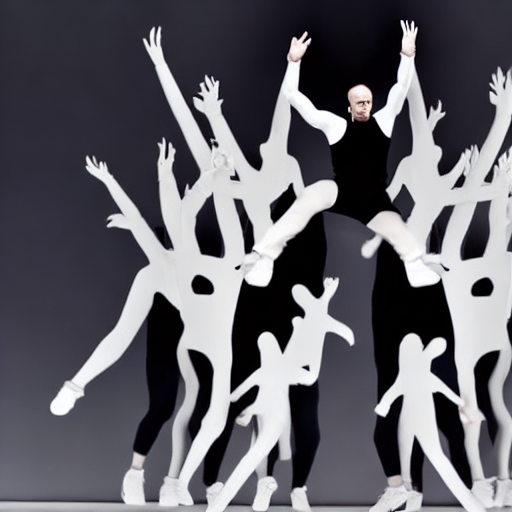

In [12]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0) # [[YOUR CODE]]

#프롬프트를 작성합니다. 
prompt = "Active man with dance"  # [[YOUR CODE]]
negative_prompt = "backgraund" # [[YOUR CODE]]

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt="Active man with dance",
    negative_prompt="backgraund",
    controlnet_conditioning_scale=1.2,
    num_inference_steps=20,
    guidance_scale=10.0,
    generator=generator,
    image=canny_image
).images[0] # [[YOUR CODE]]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/50 [00:00<?, ?it/s]

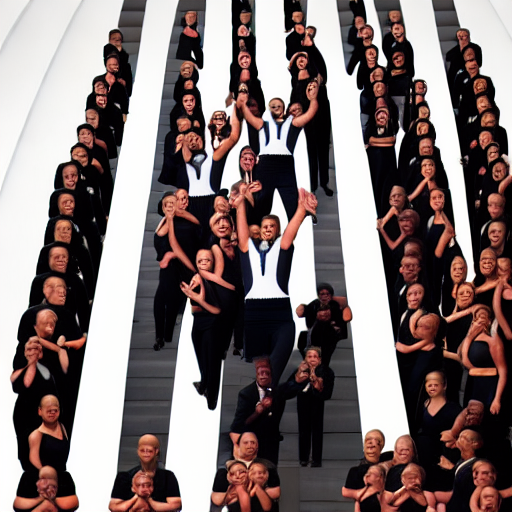

In [13]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요. 
# [[YOUR CODE]]
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(5) # [[YOUR CODE]]

#프롬프트를 작성합니다. 
prompt = "Active man with dance"  # [[YOUR CODE]]
negative_prompt = "nature backgraund" # [[YOUR CODE]]

images = openpose_image

# 이미지를 생성합니다. 
openpose_image2 = openpose_pipe(
    prompt="Active man with dance",
    negative_prompt="nature backgraund",
    controlnet_conditioning_scale=2.8,
    num_inference_steps=50,
    guidance_scale=15.0,
    generator=generator,
    image=canny_image
).images[0] # [[YOUR CODE]]

# 생성된 이미지를 출력합니다. 
openpose_image2

## 윤곽선 검출 + 인체 자세 감지
 - 2가지의 전처리기를 동시에 사용
 - controlnets라는 리스트로 만들어 파이프라인으로 전달

#### Canny 알고리즘을 사용한 윤곽선 검출

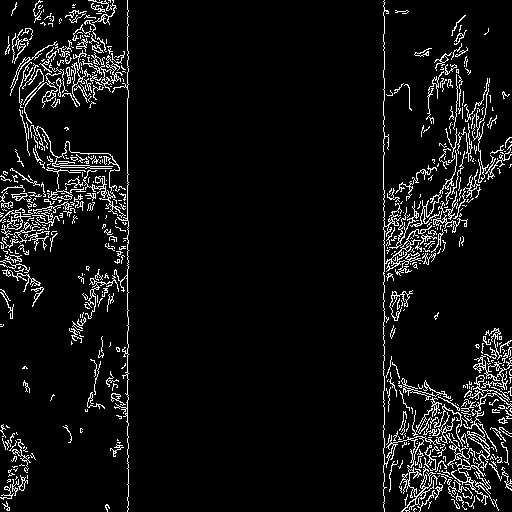

In [14]:
# 윤곽선 검출 + 인체 자세 감지

from PIL import Image
import cv2
import numpy as np

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image3 = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/landscape.png"
)


#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image3 = np.array(canny_image3)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image3.shape[1] // 4
zero_end = zero_start + canny_image3.shape[1] // 2
canny_image3[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image3 = cv2.Canny(canny_image3, low_threshold, high_threshold)
canny_image3 = canny_image3[:, :, None]
canny_image3 = np.concatenate([canny_image3, canny_image3, canny_image3], axis=2)
canny_image3 = Image.fromarray(canny_image3)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image3.show()


### Openpose를 사용한 인체 자세 검출

cuda


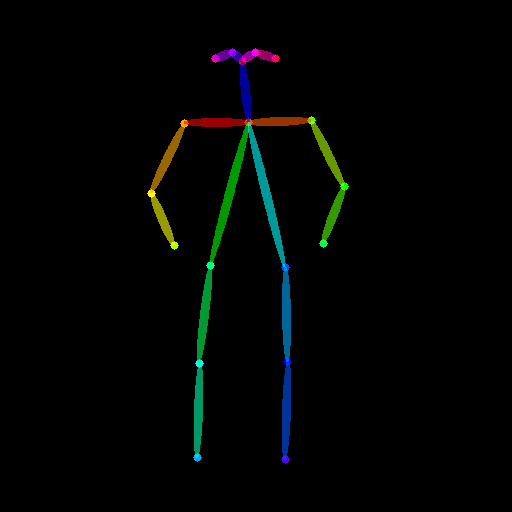

In [15]:
# Openpose를 사용한 인체 자세 검출

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image3 = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image3 = openpose(openpose_image3)

openpose_image3.show()

- Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

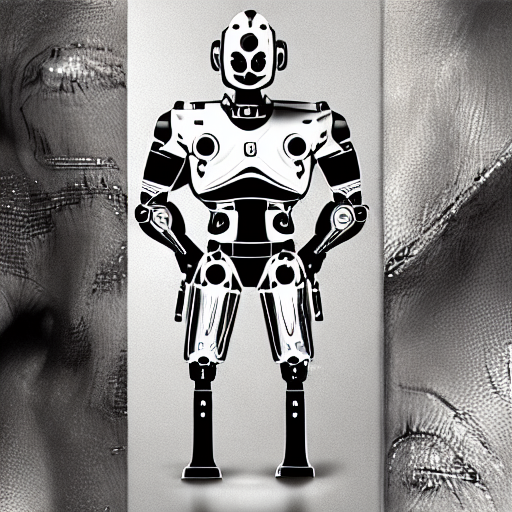

In [16]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
).to("cuda")

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "cyborg robot"
negative_prompt = "dark"


# seed를 지정합니다. 
generator = torch.Generator(device = "cuda").manual_seed(0)

images = [openpose_image3, canny_image3]

# 이미지를 생성합니다. 
canny_openpose_image3 = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt).images[0]

# 생성된 이미지를 저장합니다.
canny_openpose_image3.save("/aiffel/aiffel/canny_openpose_image3.png")

# 생성된 이미지를 출력합니다.  
canny_openpose_image3.show()


SNS에 올려 주변 사람들에게 공유

In [17]:
print("생성한 이미지를 올린 곳은 /aiffel/aiffel/multi_controlnet_output.png 입니다.")

생성한 이미지를 올린 곳은 /aiffel/aiffel/multi_controlnet_output.png 입니다.
